This Notebook studies properties of the GDP through the lens of an Anxious Unit Root Filter.
This equation is given by:

Y Equation) Delta Y_{t+1} = mu + cI(P_t = Y_t)

P equation) P_{t+1} = max(Y_{t+1}, P_t + alpha)

Our analysis will focus on two aspects:

1) Which trend in the P_t term creates the largest seperation between the means of the log GDP_t terms when conditioned on a hit or not.

2) How well does k-periods ahead forecastng do compared to a standard unit root

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 

In [2]:
#Read in bitcoin data
# bitcoin_data_df = pd.read_csv('C:/Users/Jon/Downloads/bitcoinity_data.csv')

gdp = pd.read_csv('C:/Users/Jon/Downloads/GDP (1).csv')

In [3]:
gdp['log_GDP'] = np.log(gdp['GDP'])

gdp_data = gdp[['DATE','log_GDP']].copy()

C:\Users\Jon\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


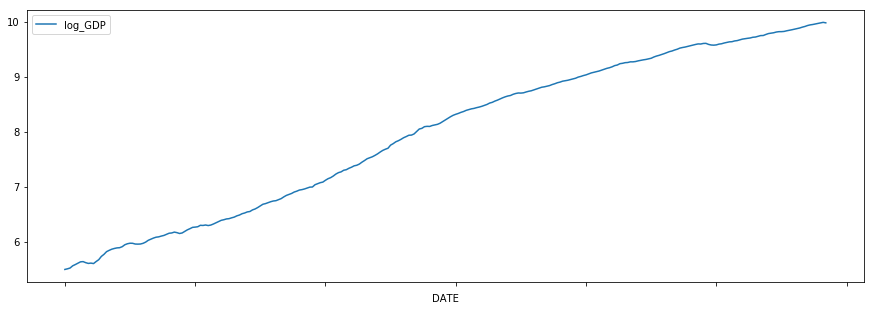

In [4]:
#Plot the data set

plt, ax = plt.subplots(figsize = (15,5))

gdp_data[['DATE','log_GDP']].plot(ax =ax, x ='DATE', y='log_GDP')
plt.show()

# We now look for the optimal alpha term for P_t to split the data

In [5]:
base_inc = .015
test_range  = np.linspace(.9,1.1, 50)

In [6]:
def generate_barrier(gdp_data, mult, base_inc):
    hit_df = gdp_data.copy()
    inc = base_inc * mult
    
    P = [gdp_data.loc[0,'log_GDP']]
    N = [0]
    
    for index in gdp_data.index:
        if index > 0:
            last_index = index-1
            new_p = max(gdp_data.loc[index,'log_GDP'], P[last_index] + inc )
            new_n = 1*(new_p == gdp_data.loc[index,'log_GDP'])
            
            P.append(new_p)
            N.append(new_n)
    
    hit_df['P'] = P
    hit_df['hit'] = N
    return hit_df
    

In [7]:
summary_df = pd.DataFrame(columns = ['hit_count','hit_mean','no_hit_mean'])

for mult in test_range:
    hit_df = generate_barrier(gdp_data, mult, base_inc)
    hit_df['lag_hit'] = hit_df['hit'].shift(1)
    hit_df['delta'] = hit_df['log_GDP'].diff(1)
    
    hit_count = hit_df['hit'].sum()
    hit_delta = hit_df.query('lag_hit == 1')['delta'].mean()
    no_hit_delta = hit_df.query('lag_hit == 0')['delta'].mean()
    
    summary_df.loc[str(round(mult,4))] = [hit_count, hit_delta, no_hit_delta]

summary_df['diff'] = summary_df['hit_mean'] - summary_df['no_hit_mean']

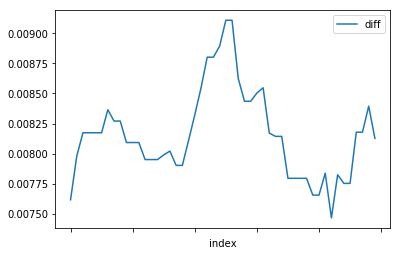

In [8]:
summary_df.reset_index().plot(x='index',y='diff')

In [9]:
largest_diff = summary_df['diff'].max() 
summary_df.query('diff == @largest_diff')

,hit_count,hit_mean,no_hit_mean,diff
1.002,58.0,0.022655,0.013547,0.009109
1.0061,58.0,0.022655,0.013547,0.009109


# Having found the most seperation with alpha equal to the mean of Delta log(GDP), we study these coefficients

In [10]:
gdp_delta = gdp_data['log_GDP'].diff(1).mean()

hit_df = generate_barrier(gdp_data, 1.0, gdp_delta)
hit_df['lag_hit'] = hit_df['hit'].shift(1)
hit_df['delta'] = hit_df['log_GDP'].diff(1)
    
hit_count = hit_df['hit'].sum()

hit_mean = hit_df.query('lag_hit == 1')['delta'].mean()
hit_sd = hit_df.query('lag_hit == 1')['delta'].std()
print('Hits have (mean, sd)=', hit_mean, hit_sd)
print()
no_hit_mean = hit_df.query('lag_hit == 0')['delta'].mean()
no_hit_sd = hit_df.query('lag_hit == 0')['delta'].std()
print('Non hits have (mean, sd)=', no_hit_mean, no_hit_sd)

Hits have (mean, sd)= 0.022315902658341512 0.009705445305995174

Non hits have (mean, sd)= 0.013812441667951423 0.010596974635364692


# We now study k-period ahead forecasts, under the assumption that Delta Y_{t+1}'s mean depends on I(Y_t = P_t). 

In [11]:
#forecast ahead
p_inc = .012
gdp_index = gdp_data.index
last_period = max(gdp_index)

no_hit_mean = .0135
hit_mean = .017

k_ahead = 13
k_ahead_error_df = pd.DataFrame(columns = ['k','error','sq_error'])

for time in [x for x in gdp_index if x>1 and (last_period > x+k_ahead)]:
    fitted_history = generate_barrier(gdp_data.loc[:time], 1.0, p_inc)

    forecast = fitted_history.loc[time:].copy().reset_index()
    forecast = forecast.drop(columns = ['index','DATE'])

    for k in range(1,k_ahead):
#     for k in range(1,2):
        last_period = k-1
        last_gdp = forecast.loc[last_period, 'log_GDP']
        last_p = forecast.loc[last_period,'P']

        last_period_hit = 1*(last_gdp == last_p)

        forecast_log_GDP = last_gdp + (no_hit_mean ) * (1-last_period_hit) + (hit_mean) * (last_period_hit)
        forecast_P = max(last_p + p_inc, forecast_log_GDP)
        hit = 1*(forecast_log_GDP == forecast_P)

        forecast.loc[k] = [forecast_log_GDP,forecast_P,hit]

    true_values = gdp_data.loc[time:(time+k_ahead - 1)]['log_GDP'].values
    forecast['true_log_GDP'] = true_values

    error_df = (forecast['log_GDP'] - forecast['true_log_GDP']).reset_index()
    error_df.columns = ['k','error']
    error_df['sq_error'] = np.square(error_df['error'])

    k_ahead_error_df = k_ahead_error_df.append(error_df)

C:\Users\Jon\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


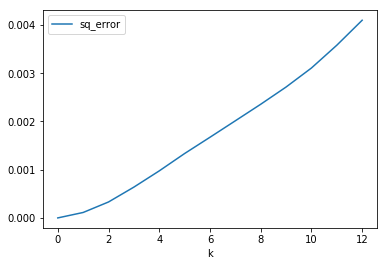

In [12]:
k_ahead_error_df[['k','sq_error']].groupby(['k']).mean().plot()
plt.show()

C:\Users\Jon\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


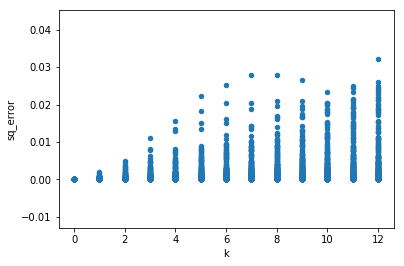

In [13]:
k_ahead_error_df['k'] = k_ahead_error_df['k'].astype('double') 
k_ahead_error_df.plot.scatter(x= 'k', y='sq_error')
plt.show()

C:\Users\Jon\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


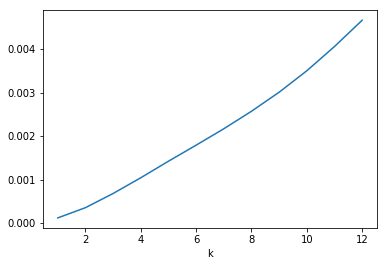

In [14]:
gdp_delta = gdp_data['log_GDP'].diff(1).mean()
unit_root_errors = pd.DataFrame(columns = ['k','mean_error','mean_square_error']).set_index('k')

for k in range(1,k_ahead):
    mean_error = (gdp_data['log_GDP'].diff(k).dropna() - k*gdp_delta  ).mean() 
    mean_square_error = np.square( (gdp_data['log_GDP'].diff(k).dropna() - k*gdp_delta)   ).mean()
    unit_root_errors.loc[k] = [mean_error, mean_square_error]
    
unit_root_errors
unit_root_errors['mean_square_error'].plot()
plt.show()

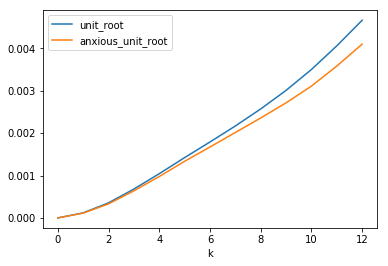

In [15]:
comparison_df = unit_root_errors[['mean_square_error']].copy()
comparison_df.loc[0] = 0
comparison_df = comparison_df.sort_index()
comparison_df['anxious_mean_sq_error'] = k_ahead_error_df[['k','sq_error']].groupby(['k']).mean().values

comparison_df.columns = ['unit_root','anxious_unit_root']
comparison_df.plot()